In [1]:
import glob
import os
from lsst import afw
print(afw.version.__version__)
from lsst.daf.persistence import Butler
from lsst.eotest.sensor import MaskedCCD, makeAmplifierGeometry

from exploreRun import exploreRun
from lsst.eo_utils.base.image_utils import get_ccd_from_id,\
    get_amp_list, get_data_as_read, sort_sflats

from lsst.eo_utils.base.data_access import get_data_for_run

import lsst.eotest.image_utils as imutil
import pylab

from astropy.io import fits
from astropy.stats import mad_std

import scipy
from scipy import signal
from scipy.fftpack import fft, fftshift

import math
from scipy.ndimage import gaussian_filter

from mytool import plotonesensor_E2V, plotonesensor_E2V_smooth, create_combined_E2V
import numpy as np
import numpy

import matplotlib.pyplot as plt

%matplotlib inline

20.0.0-4-gde602ef96+1
20.0.0-4-gde602ef96+1


[ 319.994  324.969  349.982  374.975  400.019  424.965  450.035  475.003
  500.018  525.002  550.029  575.023  599.982  619.997  624.979  650.012
  675.004  700.03   725.012  750.022  774.987  799.976  824.988  850.022
  869.967  875.002  899.999  919.999  925.012  949.965  975.002  999.976
 1025.028 1050.014 1075.002 1099.99 ]


Text(0.5, 1.0, 'Response Curve/SED for CCOB$_{R}$')

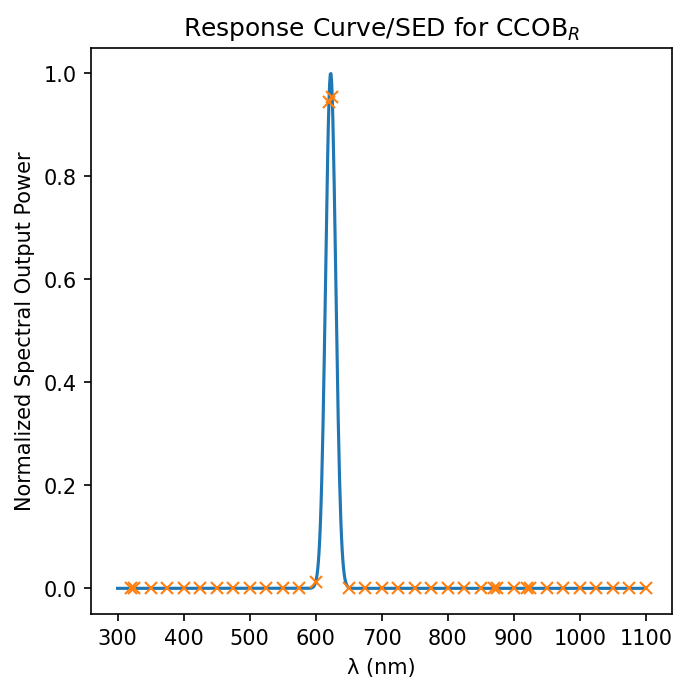

In [2]:
superbiaspath = "/gpfs/slac/lsst/fs1/u/echarles/DATA/analysis/ts8/superbias/RTM-024/RTM-024-11351-S11_superbias_normal.fits"
superdarkpath = "/gpfs/slac/lsst/fs1/u/echarles/DATA/analysis/ts8/superdark/RTM-024/RTM-024-11351-S11_superdark_normal.fits"
qeflatpath = glob.glob("/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-11021_RTM/LCA-11021_RTM-024/11351/qe_raft_acq/v0/88290/S11/*_lambda_flat_*") 
qeflatpath.sort()

# array of wavelengths
wls = numpy.array([ get_ccd_from_id(None, aqeflatpath, []).md.md["MONOWL"] for aqeflatpath in qeflatpath ])
print(wls)

# SED plot for red band
fig, axs = pylab.subplots(figsize=(5,5),dpi=150)

wavelengths_list = [365, 466.6, 622.6, 759.9, 845.7, 950.5]
width_of_wavelength_list = [12, 25, 18, 28, 32, 60]
width_of_wavelength_list_converted = []
for num in width_of_wavelength_list:
    z = num / 2.355
    width_of_wavelength_list_converted.append(z)
# now wavelength widths converted from FWHM to sigma

# want to use the RED band, so the third element in each list
mu = wavelengths_list[2]
sigma = width_of_wavelength_list_converted[2]

a = 1    # to normalize
x = numpy.arange(300,1100,1)  
y = a*numpy.exp(-(x-mu)**2/(2*sigma**2))
pylab.plot(x, y)

weights = numpy.interp(wls, x, y)   
# plots 'x's
pylab.plot(wls, weights,"x")

pylab.xlabel("λ (nm)")
pylab.ylabel("Normalized Spectral Output Power")
pylab.title("Response Curve/SED for CCOB$_{R}$")

In [5]:
### R22_S11

# Here we make the median flat level of COMBINED match the median flat level of CCOB amplifier-by-amplifier. The purpose of this cell is to normalize the COMBINED flat to the CCOBred.
# Here we are normalizing amp-by-amp rather than an overall normalization (before for loop).
# To avoid complication, the part where I divided amplifiers into two different arrays (red_top, red_bot, etc.) has been removed. Now the amp data is in ONE array. 

def create_ccob(img_list):
    num_ch = 16
    red_arr = [None] * num_ch
    normedimg_arr = [None] * num_ch
    MEDIAN = None

    fname = "/gpfs/slac/lsst/fs1/u/combet/DATA/CCOB_QE/fits/QE_R22_S11_red_-10.005_10.245.fits"     ##  center pointing
    ccob_red = get_ccd_from_id(None, fname, [])

    for ch in range(num_ch):    
        red = get_data_as_read(ccob_red,ch + 1,["imaging"])["imaging"]    # QE data array for CCOBr flat field image
        MEDIAN = numpy.median(red)                                        # median (not mean, avoiding outliers) of QE data array for CCOBred, will normalize COMBINED with this
        normedimg = img_list[ch] / numpy.median(img_list[ch]) * MEDIAN    # normalizing COMBINED against the CCOB amp-by-amp to the level of the CCOB median 
        normedimg_arr[ch] = normedimg                                     # adding data at this amp to data array
        red_arr[ch] = red        
    
    return red_arr, normedimg_arr

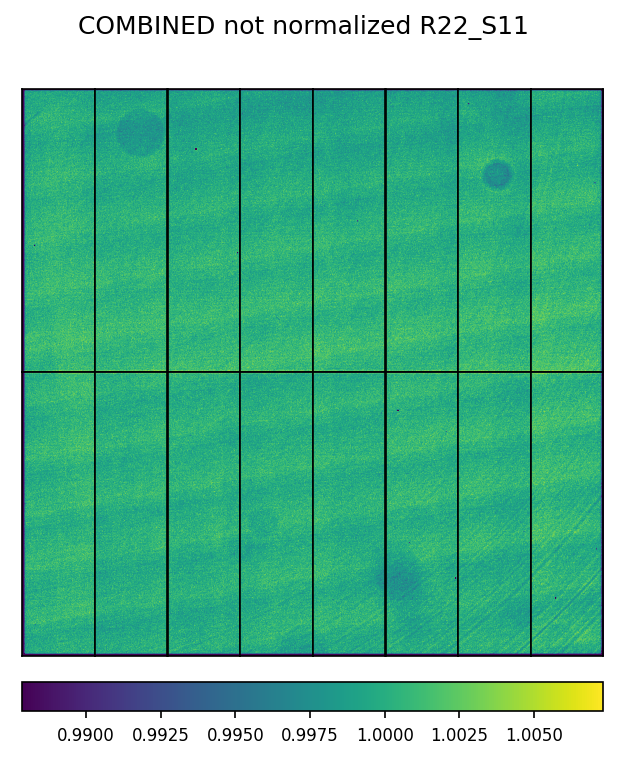

"\nLet's see how the Combined flat for FULL CCD SENSOR looks\ncreating a broadband flat (Combined) from summed up narrow band flats weighted by QE response to RED wavelength\n\nThis is fine if looking at an image before gain correction. And the COMBINED image is not gain corrected. So it's fine, but we're suspecting that the CCOB flat is gain corrected.\nThis looks different than COMBINED normalized. We have another normalization that makes the median level of COMBINED flat the median level of CCOB flat, different than here.  \n\n"

In [6]:
### GOAL: show COMBINED flat for full sensor (all amplifiers) from ts8-stand narrowband QE flats weighted and summed to make mimicked-broadband COMBINED flat

title = "COMBINED not normalized R22_S11"
img_list = create_combined_E2V(superdarkpath, superbiaspath, qeflatpath, weights, title)    # create_combined returns img_list at end of function
create_ccob(img_list)   # calling this function creates the combined flat, displays it, returns the img_list with combined data arrays, and creates data array lists for CCOB and combined normalized against CCOB

"""
Let's see how the Combined flat for FULL CCD SENSOR looks
creating a broadband flat (Combined) from summed up narrow band flats weighted by QE response to RED wavelength

This is fine if looking at an image before gain correction. And the COMBINED image is not gain corrected. So it's fine, but we're suspecting that the CCOB flat is gain corrected.
This looks different than COMBINED normalized. We have another normalization that makes the median level of COMBINED flat the median level of CCOB flat, different than here.  

"""

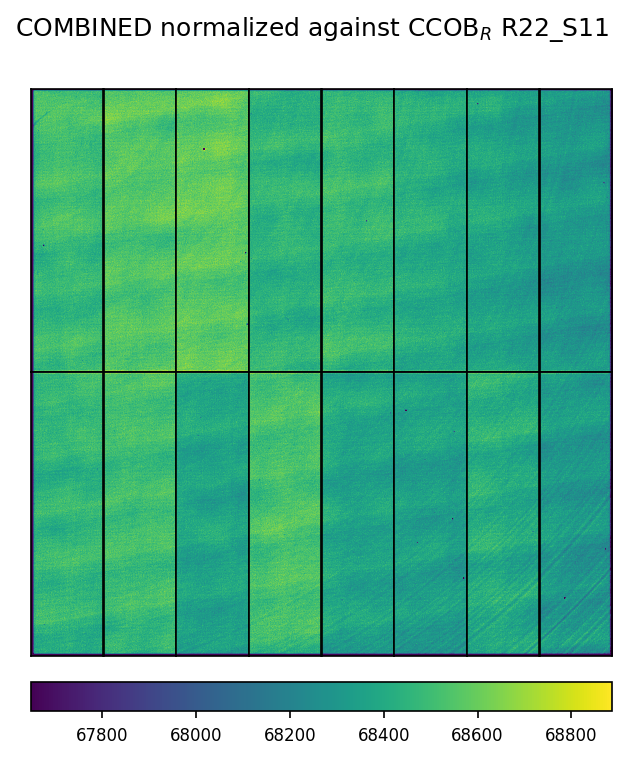

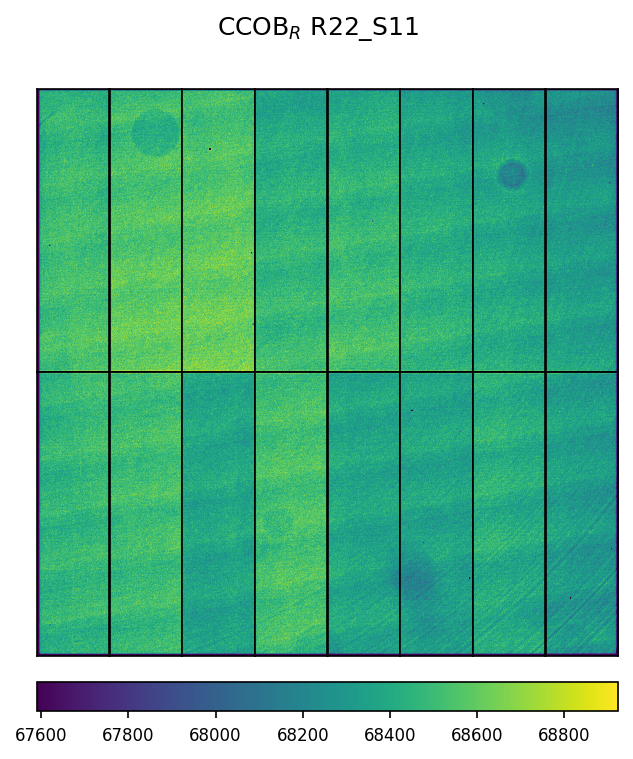

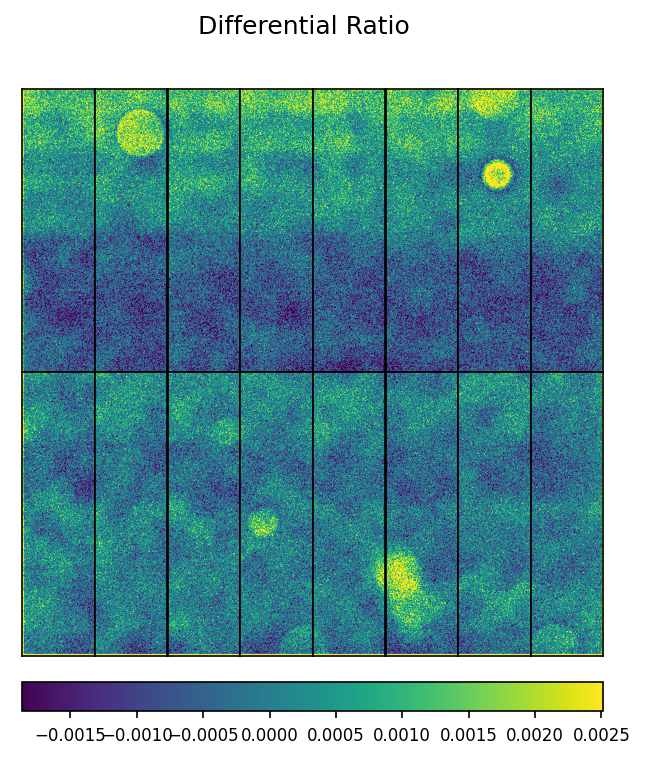

In [7]:
# default color map
num_ch = 16
normedimg_arr, red_arr = create_ccob(img_list)    # create_ccob returns these two lists to be used in plotonesensor

# plot normalized, COMBINED flat
plotonesensor_E2V(normedimg_arr, 'COMBINED normalized against CCOB$_{R}$ R22_S11')

# plot CCOBred flat
plotonesensor_E2V(red_arr, 'CCOB$_{R}$ R22_S11')

# plot Ratio flat, the one of interest!
diff_arr = [None] * num_ch
for i in range(num_ch):
    diff_arr[i] = (normedimg_arr[i] - red_arr[i]) / red_arr[i]
plotonesensor_E2V(diff_arr, 'Differential Ratio')

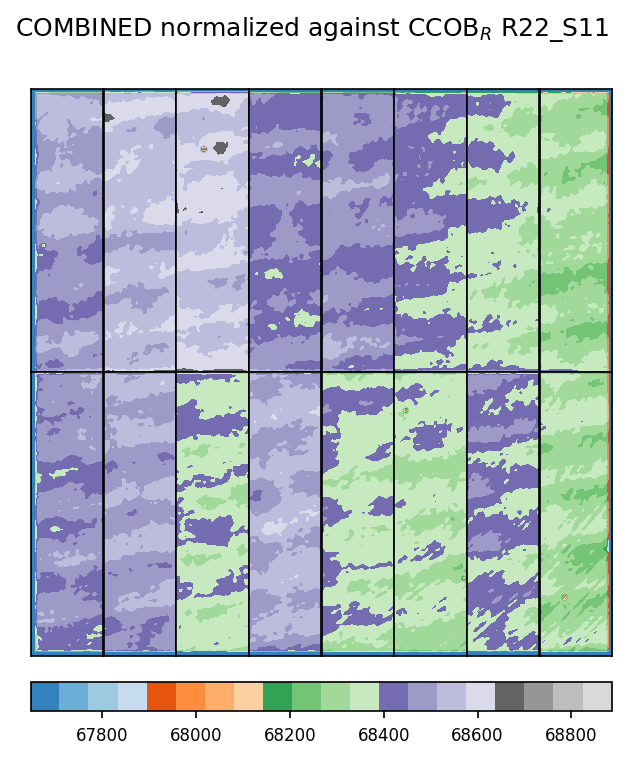

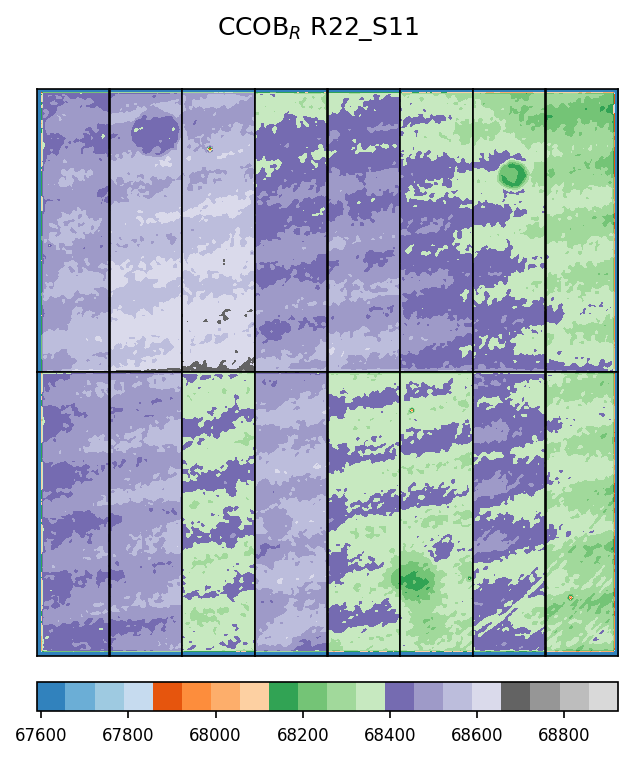

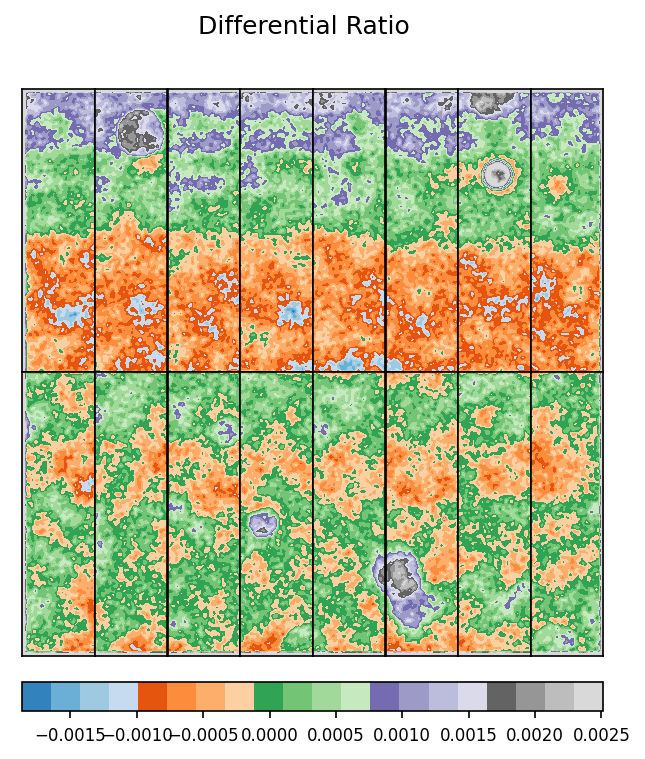

In [8]:
# Smoothed # 

# plot normalized, COMBINED flat
plotonesensor_E2V_smooth(normedimg_arr, 'COMBINED normalized against CCOB$_{R}$ R22_S11')

# plot CCOBred flat
plotonesensor_E2V_smooth(red_arr, 'CCOB$_{R}$ R22_S11')

# plot Ratio flat, the one of interest!
diff_arr = [None] * num_ch
for i in range(num_ch):
    diff_arr[i] = (normedimg_arr[i] - red_arr[i]) / red_arr[i]
plotonesensor_E2V_smooth(diff_arr, 'Differential Ratio')
    


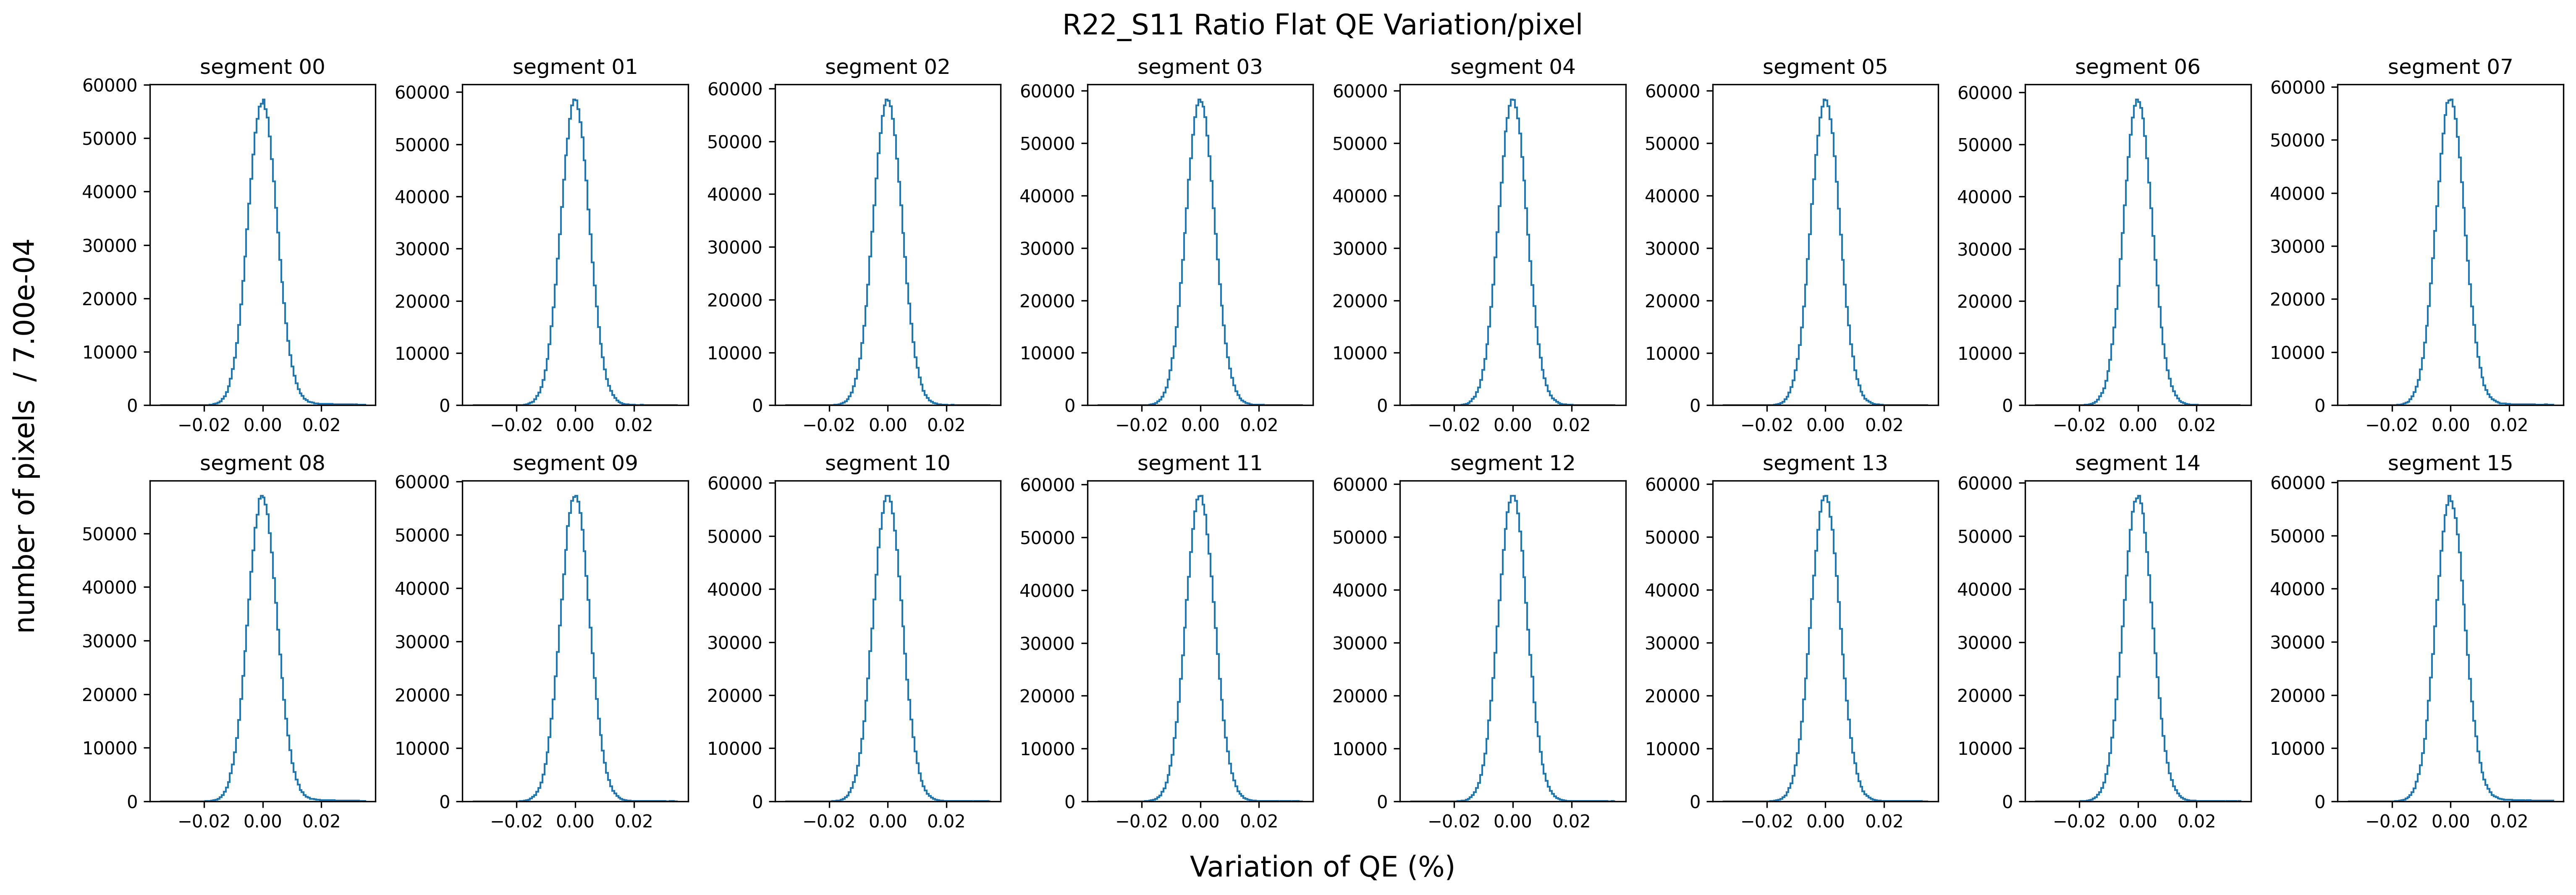

In [9]:
xmin= -0.035
xmax= 0.035
nbins= 101
bins= np.linspace(xmin, xmax, nbins)
width = (xmax-xmin)/ (nbins-1)


# creating histogram plots for R22_S11 ratio
fig, axs = plt.subplots(2, 8, figsize=(20,7),dpi=300) 
rows = 2    
columns = 8 
axs = axs.ravel()

fig.suptitle('R22_S11 Ratio Flat QE Variation/pixel', fontsize=16)
fig.text(0.5, 0.0, "Variation of QE (%)", ha='center', fontsize=16)
fig.text(-0.02, 0.5, "number of pixels  / %.2e" % width, va='center', rotation='vertical', fontsize=16)

for i in range(16):
    x = (normedimg_arr[i] - red_arr[i]) / red_arr[i]
    
    axs[i].hist(x.flat, bins=bins, histtype='step')
    
    if i > 9:
        axs[i].set_title("segment " + str(i))
    else:
        axs[i].set_title("segment 0" + str(i))
    
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()